# OPTICS Signals: Transient & Stable Pair Strategies

In [1]:
# ============================================================================
# IMPORTS & LOAD ARTIFACTS
# ============================================================================

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import pearsonr, norm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath('__file__')), '..'))
from validation.pair_validation import (
    compute_hedge_ratio, hedge_ratio_drift, spread_cv_normalized,
    half_life, zscore_signals, simulate_spread_pnl,
)

# Load artifacts from Notebook 1
data_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data')

artifact_names = [
    'ts_df', 'df_formations', 'df_formations_actionable',
    'pair_classification', 'cluster_history', 'df_durations',
    'df_pair_stability', 'oos_split_timestamp', 'pair_co_cluster_freq',
]

artifacts = {}
for name in artifact_names:
    path = os.path.join(data_dir, f'{name}.pkl')
    with open(path, 'rb') as f:
        artifacts[name] = pickle.load(f)
    print(f'Loaded {name} ({type(artifacts[name]).__name__})')

# Unpack into local variables
ts_df = artifacts['ts_df']
df_formations = artifacts['df_formations']
df_formations_actionable = artifacts['df_formations_actionable']
pair_classification = artifacts['pair_classification']
cluster_history = artifacts['cluster_history']
df_durations = artifacts['df_durations']
df_pair_stability = artifacts['df_pair_stability']
oos_split_timestamp = artifacts['oos_split_timestamp']
pair_co_cluster_freq = artifacts['pair_co_cluster_freq']

print(f"\nLoaded all artifacts successfully.")
print(f"ts_df: {len(ts_df)} rows, {ts_df.index.get_level_values('Ticker').nunique()} tickers")
print(f"Actionable formations: {len(df_formations_actionable)}")
print(f"Pair classifications: {len(pair_classification)}")

Loaded ts_df (DataFrame)
Loaded df_formations (DataFrame)
Loaded df_formations_actionable (DataFrame)
Loaded pair_classification (DataFrame)
Loaded cluster_history (DataFrame)
Loaded df_durations (DataFrame)
Loaded df_pair_stability (DataFrame)
Loaded oos_split_timestamp (Timestamp)
Loaded pair_co_cluster_freq (dict)

Loaded all artifacts successfully.
ts_df: 63143 rows, 40 tickers
Actionable formations: 20242
Pair classifications: 776


## Helper Functions

In [2]:
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def get_price_window(ticker, timestamp, window_obs, ts_df, direction='forward'):
    """
    Extract price data for a ticker over a window of N observations.
    Uses the MultiIndex (Datetime, Ticker) structure of ts_df.
    """
    try:
        ticker_data = ts_df.xs(ticker, level='Ticker').sort_index()
        if timestamp not in ticker_data.index:
            idx_pos = ticker_data.index.searchsorted(timestamp)
            if idx_pos >= len(ticker_data.index):
                return pd.Series(dtype=float)
            timestamp = ticker_data.index[idx_pos]
        loc = ticker_data.index.get_loc(timestamp)
        if direction == 'forward':
            end_loc = min(loc + window_obs, len(ticker_data))
            return ticker_data.iloc[loc:end_loc]['Price']
        else:
            start_loc = max(0, loc - window_obs + 1)
            return ticker_data.iloc[start_loc:loc + 1]['Price']
    except Exception:
        return pd.Series(dtype=float)


def get_daily_prices(ticker, ts_df):
    """Resample hourly prices to daily (last observation per day)."""
    try:
        ticker_data = ts_df.xs(ticker, level='Ticker').sort_index()['Price']
        return ticker_data.resample('1D').last().dropna()
    except Exception:
        return pd.Series(dtype=float)


def validate_transient_event(ticker_a, ticker_b, timestamp, ts_df, config):
    """
    Validate a single transient pair event using three-window approach:
      - Execution lag: skip first EXECUTION_LAG obs after formation
      - Calibration window: estimate hedge ratio
      - Exploitation window: test spread metrics + generate signals + simulate P&L

    Parameters
    ----------
    config : dict with keys CALIBRATION, EXPLOITATION, EXECUTION_LAG,
             CORR_THRESHOLD, CV_THRESHOLD, HL_MAX, HEDGE_DRIFT_MAX, ENTRY_Z, EXIT_Z

    Returns
    -------
    dict with all metrics + pass/fail, or None if insufficient data.
    """
    lag = config['EXECUTION_LAG']
    cal_len = config['CALIBRATION']
    exploit_len = config['EXPLOITATION']
    total_need = lag + cal_len + exploit_len

    prices_a = get_price_window(ticker_a, timestamp, total_need, ts_df, direction='forward')
    prices_b = get_price_window(ticker_b, timestamp, total_need, ts_df, direction='forward')

    if len(prices_a) < total_need or len(prices_b) < total_need:
        return None

    common_idx = prices_a.index.intersection(prices_b.index)
    pa = prices_a.loc[common_idx]
    pb = prices_b.loc[common_idx]
    if len(pa) < total_need:
        return None

    # Split into windows
    pa_cal = pa.iloc[lag:lag + cal_len]
    pb_cal = pb.iloc[lag:lag + cal_len]
    pa_exploit = pa.iloc[lag + cal_len:lag + cal_len + exploit_len]
    pb_exploit = pb.iloc[lag + cal_len:lag + cal_len + exploit_len]

    if len(pa_cal) < 5 or len(pa_exploit) < 10:
        return None

    # Calibration: estimate hedge ratio
    beta_cal, intercept_cal, r_sq_cal = compute_hedge_ratio(pa_cal, pb_cal, method='ols')
    if np.isnan(beta_cal):
        return None

    # Exploitation: compute metrics
    spread_exploit = pa_exploit - beta_cal * pb_exploit
    cv = spread_cv_normalized(spread_exploit, pa_exploit, pb_exploit)
    hl = half_life(spread_exploit)

    # Returns correlation on exploitation window
    ret_a = pa_exploit.pct_change().dropna()
    ret_b = pb_exploit.pct_change().dropna()
    common_ret = ret_a.index.intersection(ret_b.index)
    if len(common_ret) < 10:
        corr = np.nan
    else:
        corr, _ = pearsonr(ret_a.loc[common_ret], ret_b.loc[common_ret])

    # Hedge ratio drift (FIX 6)
    beta_exploit_val, _, _ = compute_hedge_ratio(pa_exploit, pb_exploit, method='ols')
    drift = hedge_ratio_drift(beta_cal, beta_exploit_val)

    # Z-score signals on exploitation spread
    lookback = min(20, len(spread_exploit) // 2)
    if lookback < 5:
        lookback = 5
    signals = zscore_signals(spread_exploit, lookback=lookback,
                             entry_z=config['ENTRY_Z'], exit_z=config['EXIT_Z'])

    # Simulate P&L
    pnl_result = simulate_spread_pnl(spread_exploit, signals, cost_per_trade=0.0)

    has_signal = signals['long_entry'].any() or signals['short_entry'].any()

    # Pass/fail
    passed = (
        (not np.isnan(corr)) and corr > config['CORR_THRESHOLD']
        and (not np.isnan(cv)) and cv < config['CV_THRESHOLD']
        and (not np.isnan(hl)) and hl < config['HL_MAX'] and hl > 0
        and (not np.isnan(drift)) and drift < config['HEDGE_DRIFT_MAX']
        and has_signal
    )

    return {
        'ticker_a': ticker_a,
        'ticker_b': ticker_b,
        'timestamp': timestamp,
        'beta_cal': beta_cal,
        'r_squared_cal': r_sq_cal,
        'correlation': corr,
        'spread_cv': cv,
        'half_life': hl,
        'hedge_drift': drift,
        'has_signal': has_signal,
        'n_trades': pnl_result['n_trades'],
        'total_pnl': pnl_result['total_pnl'],
        'win_rate': pnl_result['win_rate'],
        'sharpe': pnl_result['sharpe'],
        'max_drawdown': pnl_result['max_drawdown'],
        'passed': passed,
    }

## Transient Pair Strategy

In [3]:
# ============================================================================
# TRANSIENT PAIR VALIDATION (FIX 2, 3, 5, 6)
# ============================================================================
# FIX 2: Separate calibration/exploitation windows (no circular validation)
# FIX 3: Tighter, transient-appropriate thresholds (drop cointegration)
# FIX 5: Only use actionable formations (>= 5h duration)
# FIX 6: Check hedge ratio drift between calibration and exploitation

TRANSIENT_CONFIG = {
    'CALIBRATION': 20,        # hours for hedge ratio estimation (increased from 10 for stability)
    'EXPLOITATION': 40,       # hours for out-of-sample testing
    'EXECUTION_LAG': 2,       # hours delay before entering (FIX 5)
    'CORR_THRESHOLD': 0.70,   # returns correlation (FIX 3: tighter)
    'CV_THRESHOLD': 0.03,     # spread CV normalized (FIX 3: tighter)
    'HL_MAX': 8,              # max half-life in hours (FIX 3: transient)
    'HEDGE_DRIFT_MAX': 0.20,  # max hedge ratio drift (FIX 6)
    'ENTRY_Z': 2.0,
    'EXIT_Z': 0.5,
}

MAX_PAIRS = 50
MAX_EVENTS_PER_PAIR = 20

print(f"{'='*80}")
print("TRANSIENT PAIR VALIDATION")
print(f"{'='*80}")
print(f"\nConfig: {TRANSIENT_CONFIG}")
print(f"Max pairs: {MAX_PAIRS}, max events/pair: {MAX_EVENTS_PER_PAIR}")
print(f"OOS split timestamp: {oos_split_timestamp}")

# Select transient pairs from classification
transient_classified = pair_classification[pair_classification['Category'] == 'transient']
transient_pair_names = set(transient_classified['Pair'].values)
transient_pairs = df_pair_stability[
    df_pair_stability['Pair'].isin(transient_pair_names)
].head(MAX_PAIRS)

print(f"Testing {len(transient_pairs)} transient pairs")

# Filter actionable formations to OOS period only
df_formations_oos = df_formations_actionable[
    df_formations_actionable['Formation_Time'] > oos_split_timestamp
]
print(f"Actionable formations (all): {len(df_formations_actionable)}")
print(f"Actionable formations (OOS only): {len(df_formations_oos)}")

# Validation loop on OOS actionable formations
transient_results = []
for _, pair_row in transient_pairs.iterrows():
    ticker_a = pair_row['Ticker_1']
    ticker_b = pair_row['Ticker_2']
    pair_name = f"{ticker_a}-{ticker_b}"

    pair_events = df_formations_oos[
        df_formations_oos['Pair'] == pair_name
    ].head(MAX_EVENTS_PER_PAIR)

    for _, event in pair_events.iterrows():
        result = validate_transient_event(
            ticker_a, ticker_b, event['Formation_Time'],
            ts_df, TRANSIENT_CONFIG
        )
        if result is not None:
            transient_results.append(result)

df_transient = pd.DataFrame(transient_results)

print(f"\nResults: {len(df_transient)} events tested")
if len(df_transient) > 0:
    n_passed = df_transient['passed'].sum()
    print(f"Passed: {n_passed} ({n_passed/len(df_transient):.1%})")
    print(f"Avg P&L (passed): {df_transient[df_transient['passed']]['total_pnl'].mean():.4f}")
    print(f"Avg trades (passed): {df_transient[df_transient['passed']]['n_trades'].mean():.1f}")

TRANSIENT PAIR VALIDATION

Config: {'CALIBRATION': 20, 'EXPLOITATION': 40, 'EXECUTION_LAG': 2, 'CORR_THRESHOLD': 0.7, 'CV_THRESHOLD': 0.03, 'HL_MAX': 8, 'HEDGE_DRIFT_MAX': 0.2, 'ENTRY_Z': 2.0, 'EXIT_Z': 0.5}
Max pairs: 50, max events/pair: 20
OOS split timestamp: 2025-10-31 13:30:00+00:00
Testing 50 transient pairs
Actionable formations (all): 20242
Actionable formations (OOS only): 6670



Results: 657 events tested
Passed: 26 (4.0%)
Avg P&L (passed): 1.9372
Avg trades (passed): 1.2


In [4]:
# ============================================================================
# RANDOM-PAIR BASELINE (FIX 2, FIX 10)
# ============================================================================
# Test the same validation on NON-co-clustered pairs at the same timestamps.
# If clustered pairs don't outperform random pairs, the clustering adds
# no value to pair selection.
# FIX 10: Only use formation timestamps from the OOS period to match the
# transient analysis, avoiding train-period contamination.

print(f"{'='*80}")
print("RANDOM-PAIR BASELINE")
print(f"{'='*80}")

# Select pairs that rarely co-cluster (frequency < 0.03)
rare_pairs = df_pair_stability[
    df_pair_stability['Co_Cluster_Frequency'] < 0.03
]

if len(rare_pairs) == 0:
    print("WARNING: No rare co-clustering pairs found for baseline.")
    df_random = pd.DataFrame()
else:
    # Sample up to MAX_PAIRS random pairs
    random_pairs = rare_pairs.sample(n=min(MAX_PAIRS, len(rare_pairs)), random_state=42)

    # FIX 10: Only use formation timestamps from the OOS period
    formation_timestamps = df_formations_actionable[
        df_formations_actionable['Formation_Time'] > oos_split_timestamp
    ]['Formation_Time'].unique()

    print(f"Using {len(formation_timestamps)} OOS formation timestamps (after {oos_split_timestamp})")

    rng = np.random.default_rng(42)

    # Sample different timestamps per pair to avoid temporal correlation
    random_results = []
    for _, pair_row in random_pairs.iterrows():
        ticker_a = pair_row['Ticker_1']
        ticker_b = pair_row['Ticker_2']

        if len(formation_timestamps) == 0:
            continue

        pair_timestamps = rng.choice(
            formation_timestamps,
            size=min(MAX_EVENTS_PER_PAIR, len(formation_timestamps)),
            replace=False
        )

        for ts in pair_timestamps:
            result = validate_transient_event(
                ticker_a, ticker_b, ts,
                ts_df, TRANSIENT_CONFIG
            )
            if result is not None:
                random_results.append(result)

    df_random = pd.DataFrame(random_results)

    print(f"\nRandom baseline: {len(df_random)} events tested")
    if len(df_random) > 0:
        n_passed_rand = df_random['passed'].sum()
        print(f"Passed: {n_passed_rand} ({n_passed_rand/len(df_random):.1%})")
        print(f"Avg P&L (passed): {df_random[df_random['passed']]['total_pnl'].mean():.4f}" if n_passed_rand > 0 else "No passes")

RANDOM-PAIR BASELINE
Using 417 OOS formation timestamps (after 2025-10-31 13:30:00+00:00)



Random baseline: 889 events tested
Passed: 7 (0.8%)
Avg P&L (passed): 4.6692


In [5]:
# ============================================================================
# TRANSIENT RESULTS ANALYSIS: Clustered vs Random
# ============================================================================

print(f"{'='*80}")
print("CLUSTERED vs RANDOM COMPARISON")
print(f"{'='*80}")

if len(df_transient) > 0:
    clust_pass_rate = df_transient['passed'].mean()
    print(f"\nClustered pairs:")
    print(f"  Events tested:  {len(df_transient)}")
    print(f"  Pass rate:      {clust_pass_rate:.1%}")
    print(f"  Avg correlation (all): {df_transient['correlation'].mean():.3f}")
    print(f"  Avg spread CV (all):   {df_transient['spread_cv'].mean():.4f}")
    print(f"  Avg half-life (all):   {df_transient['half_life'].replace([np.inf], np.nan).mean():.1f}h")
    print(f"  Avg hedge drift (all): {df_transient['hedge_drift'].mean():.3f}")

    passed_trans = df_transient[df_transient['passed']]
    if len(passed_trans) > 0:
        print(f"\n  Passed events:")
        print(f"    Avg P&L:       {passed_trans['total_pnl'].mean():.4f}")
        print(f"    Avg win rate:  {passed_trans['win_rate'].mean():.1%}")
        print(f"    Avg trades:    {passed_trans['n_trades'].mean():.1f}")

        # Top pairs
        pair_counts = passed_trans.groupby(['ticker_a', 'ticker_b']).agg(
            n_passed=('passed', 'sum'),
            avg_pnl=('total_pnl', 'mean'),
            avg_cv=('spread_cv', 'mean'),
        ).sort_values('n_passed', ascending=False).head(10)
        print(f"\n  Top 10 pairs by pass count:")
        print(pair_counts.to_string())

if len(df_random) > 0:
    rand_pass_rate = df_random['passed'].mean()
    print(f"\nRandom (non-clustered) pairs:")
    print(f"  Events tested:  {len(df_random)}")
    print(f"  Pass rate:      {rand_pass_rate:.1%}")
    print(f"  Avg correlation: {df_random['correlation'].mean():.3f}")
    print(f"  Avg spread CV:   {df_random['spread_cv'].mean():.4f}")

    if len(df_transient) > 0:
        lift = clust_pass_rate / rand_pass_rate if rand_pass_rate > 0 else float('inf')
        print(f"\n  Clustered lift over random: {lift:.1f}x")

        # P&L comparison
        clust_pnl = df_transient[df_transient['passed']]['total_pnl'].values
        rand_pnl = df_random[df_random['passed']]['total_pnl'].values
        if len(clust_pnl) > 0 and len(rand_pnl) > 0:
            print(f"  Avg P&L clustered: {clust_pnl.mean():.4f}")
            print(f"  Avg P&L random:    {rand_pnl.mean():.4f}")

CLUSTERED vs RANDOM COMPARISON

Clustered pairs:
  Events tested:  657
  Pass rate:      4.0%
  Avg correlation (all): 0.550
  Avg spread CV (all):   0.0255
  Avg half-life (all):   11.8h
  Avg hedge drift (all): 1.626

  Passed events:
    Avg P&L:       1.9372
    Avg win rate:  76.9%
    Avg trades:    1.2

  Top 10 pairs by pass count:
                   n_passed   avg_pnl    avg_cv
ticker_a ticker_b                              
MCHP     TXN              4  0.777474  0.004979
NXPI     POWI             3  1.137062  0.013747
CAMT     NVMI             2  8.555518  0.006582
LRCX     MU               2  3.528340  0.010750
NVDA     TSM              2  2.003370  0.007396
STM      SWKS             2  0.020422  0.005204
STX      WDC              2  4.837007  0.011351
ASML     LRCX             1  6.263271  0.019131
         TSM              1 -4.335307  0.013405
GFS      ON               1  0.645471  0.011178

Random (non-clustered) pairs:
  Events tested:  889
  Pass rate:      0.8%
  Avg 

## Duration Prediction Model

In [6]:
# ============================================================================
# DURATION PREDICTION: Will episode last >= 10h? (FIX 5)
# ============================================================================

print(f"{'='*80}")
print("DURATION PREDICTION MODEL")
print(f"{'='*80}")

DURATION_TARGET_HOURS = 10

if len(df_durations) < 50:
    print("Insufficient duration data for modeling.")
else:
    # Build feature matrix from formation-time features
    duration_features = []
    for _, row in df_durations.iterrows():
        ticker_a, ticker_b = row['Ticker_1'], row['Ticker_2']
        ts = row['Formation_Time']
        target = 1 if row['Duration_Hours'] >= DURATION_TARGET_HOURS else 0

        try:
            snapshot = ts_df.xs(ts, level='Datetime')
            feat_a = snapshot.loc[ticker_a]
            feat_b = snapshot.loc[ticker_b]
        except (KeyError, TypeError):
            continue

        # Average features across the pair
        feat_cols = [c for c in ts_df.columns if c not in ['Price', 'Returns']]
        feat_avg = {}
        for col in feat_cols:
            if col in feat_a.index and col in feat_b.index:
                feat_avg[col] = (feat_a[col] + feat_b[col]) / 2.0
                feat_avg[f'{col}_diff'] = abs(float(feat_a[col]) - float(feat_b[col]))

        # Pair-specific historical features (strongest duration predictors)
        pair_name = f"{ticker_a}-{ticker_b}"
        past_episodes = df_durations[
            (df_durations['Pair'] == pair_name) &
            (df_durations['Formation_Time'] < ts)
        ]
        feat_avg['hist_formation_count'] = len(past_episodes)
        feat_avg['hist_avg_duration'] = past_episodes['Duration_Hours'].mean() if len(past_episodes) > 0 else 0.0
        if len(past_episodes) > 0:
            last_formation = past_episodes['Formation_Time'].max()
            delta = (pd.Timestamp(ts) - pd.Timestamp(last_formation))
            feat_avg['hours_since_last'] = delta.total_seconds() / 3600.0
        else:
            feat_avg['hours_since_last'] = 9999.0

        feat_avg['target'] = target
        feat_avg['formation_ts'] = ts
        duration_features.append(feat_avg)

    df_dur_model = pd.DataFrame(duration_features).dropna()

    if len(df_dur_model) < 30:
        print(f"Only {len(df_dur_model)} samples with features; skipping model.")
    else:
        # Sort by time for proper CV
        df_dur_model = df_dur_model.sort_values('formation_ts').reset_index(drop=True)
        feature_cols = [c for c in df_dur_model.columns if c not in ['target', 'formation_ts']]
        X = df_dur_model[feature_cols].values
        y = df_dur_model['target'].values

        print(f"Samples: {len(df_dur_model)}, Features: {len(feature_cols)}")
        print(f"Positive rate (>= {DURATION_TARGET_HOURS}h): {y.mean():.1%}")

        # TimeSeriesSplit CV
        tscv = TimeSeriesSplit(n_splits=5)
        aucs, precs, recs = [], [], []

        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
                continue

            model = LogisticRegression(max_iter=1000, C=0.1)
            model.fit(X_train, y_train)
            y_prob = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

            aucs.append(roc_auc_score(y_test, y_prob))
            precs.append(precision_score(y_test, y_pred, zero_division=0))
            recs.append(recall_score(y_test, y_pred, zero_division=0))

        if aucs:
            print(f"\nTimeSeriesSplit CV Results (5 folds):")
            print(f"  AUC:       {np.mean(aucs):.3f} +/- {np.std(aucs):.3f}")
            print(f"  Precision: {np.mean(precs):.3f} +/- {np.std(precs):.3f}")
            print(f"  Recall:    {np.mean(recs):.3f} +/- {np.std(recs):.3f}")
        else:
            print("Could not compute CV metrics (insufficient class diversity).")

DURATION PREDICTION MODEL


Samples: 20242, Features: 29
Positive rate (>= 10h): 30.1%



TimeSeriesSplit CV Results (5 folds):
  AUC:       0.653 +/- 0.008
  Precision: 0.551 +/- 0.110
  Recall:    0.170 +/- 0.127


## Stable Pair Strategy

In [7]:
# ============================================================================
# STABLE PAIR STRATEGY (FIX 3: Separate stable criteria, FIX 9: Cal/OOS split)
# ============================================================================
# For stable_candidate pairs: daily data, cointegration, Hurst, Bollinger
# FIX 9: Hedge ratio computed on calibration window only; backtest on OOS.

print(f"{'='*80}")
print("STABLE PAIR VALIDATION")
print(f"{'='*80}")

stable_candidates = pair_classification[
    pair_classification['Category'] == 'stable_candidate'
].sort_values('Co_Cluster_Frequency', ascending=False) if 'pair_classification' in dir() else pd.DataFrame()

print(f"Stable candidates: {len(stable_candidates)}")

stable_results = []

for _, row in stable_candidates.iterrows():
    pair_name = row['Pair']
    tickers = pair_name.split('-')
    if len(tickers) != 2:
        continue
    ticker_a, ticker_b = tickers

    # Resample to daily
    daily_a = get_daily_prices(ticker_a, ts_df)
    daily_b = get_daily_prices(ticker_b, ts_df)

    # Align on common dates
    common_dates = daily_a.index.intersection(daily_b.index)
    if len(common_dates) < 100:
        continue
    da = daily_a.loc[common_dates]
    db = daily_b.loc[common_dates]

    # FIX 9: Cal/OOS split at 67%
    split_idx = int(len(common_dates) * 0.67)
    if split_idx < 60 or (len(common_dates) - split_idx) < 30:
        continue  # skip pairs without enough data for both windows

    da_cal, da_oos = da.iloc[:split_idx], da.iloc[split_idx:]
    db_cal, db_oos = db.iloc[:split_idx], db.iloc[split_idx:]

    # Hedge ratio on CALIBRATION only
    beta, intercept, r_sq = compute_hedge_ratio(da_cal, db_cal, method='ols')
    if np.isnan(beta):
        continue

    # Calibration spread for metrics
    spread_cal = da_cal - beta * db_cal

    # OOS spread for backtesting
    spread_oos = da_oos - beta * db_oos

    # Engle-Granger cointegration on CALIBRATION
    try:
        _, coint_pval, _ = coint(da_cal, db_cal)
    except Exception:
        coint_pval = 1.0

    # Half-life on CALIBRATION spread
    hl = half_life(spread_cal)

    # Hurst exponent (variance ratio method) on CALIBRATION spread
    def hurst_variance_ratio(ts, max_lag=20):
        ts = np.asarray(ts, dtype=float)
        ts = ts[~np.isnan(ts)]
        if len(ts) < max_lag * 2:
            return np.nan
        lags = range(2, max_lag + 1)
        tau = []
        for lag in lags:
            diffs = ts[lag:] - ts[:-lag]
            tau.append(np.nanstd(diffs))
        if any(t == 0 for t in tau):
            return np.nan
        log_lags = np.log(list(lags))
        log_tau = np.log(tau)
        coef = np.polyfit(log_lags, log_tau, 1)
        return coef[0]

    hurst = hurst_variance_ratio(spread_cal.values)

    # Spread CV on CALIBRATION
    cv = spread_cv_normalized(spread_cal, da_cal, db_cal)

    # Pass criteria for stable (based on calibration metrics)
    passed = (
        coint_pval < 0.05
        and (not np.isnan(hl)) and 5 <= hl <= 60
        and (not np.isnan(hurst)) and hurst < 0.5
    )

    # Bollinger signals and backtest on OOS spread only
    lookback_daily = min(20, len(spread_oos) // 3)
    if lookback_daily >= 5:
        signals = zscore_signals(spread_oos, lookback=lookback_daily, entry_z=2.0, exit_z=0.5)
        pnl_result = simulate_spread_pnl(spread_oos, signals)
    else:
        pnl_result = {'total_pnl': 0, 'n_trades': 0, 'win_rate': np.nan, 'sharpe': np.nan, 'max_drawdown': 0}

    stable_results.append({
        'pair': pair_name,
        'ticker_a': ticker_a,
        'ticker_b': ticker_b,
        'n_daily_obs': len(common_dates),
        'n_cal_obs': len(da_cal),
        'n_oos_obs': len(da_oos),
        'beta': beta,
        'r_squared': r_sq,
        'coint_pval': coint_pval,
        'half_life_days': hl,
        'hurst': hurst,
        'spread_cv': cv,
        'passed': passed,
        'total_pnl': pnl_result['total_pnl'],
        'n_trades': pnl_result['n_trades'],
        'win_rate': pnl_result['win_rate'],
        'sharpe': pnl_result['sharpe'],
    })

df_stable = pd.DataFrame(stable_results)

if len(df_stable) > 0:
    n_passed = df_stable['passed'].sum()
    print(f"\nResults: {len(df_stable)} pairs tested")
    print(f"Passed all criteria (cointegrated + hl 5-60d + Hurst<0.5): {n_passed}")
    print(f"Note: Hedge ratio fitted on calibration (67%), backtest on OOS (33%)")

    # Diagnostic: show which criteria each pair passes
    print(f"\nDetailed criteria breakdown:")
    for _, r in df_stable.iterrows():
        c = 'Y' if r['coint_pval'] < 0.05 else 'N'
        h = 'Y' if (not np.isnan(r['half_life_days']) and 5 <= r['half_life_days'] <= 60) else 'N'
        hu = 'Y' if (not np.isnan(r['hurst']) and r['hurst'] < 0.5) else 'N'
        print(f"  {r['pair']:12s}  coint_p={r['coint_pval']:.4f}[{c}]  hl={r['half_life_days']:7.1f}d[{h}]  "
              f"hurst={r['hurst']:.3f}[{hu}]  pnl={r['total_pnl']:.4f}  trades={r['n_trades']}")

    if n_passed > 0:
        print(f"\nPassing stable pairs:")
        print(df_stable[df_stable['passed']][
            ['pair', 'coint_pval', 'half_life_days', 'hurst', 'total_pnl', 'n_trades']
        ].to_string(index=False))

    # Near-misses: pairs passing 2 of 3 criteria
    near = df_stable[~df_stable['passed']].copy()
    near['criteria_met'] = (
        (near['coint_pval'] < 0.05).astype(int) +
        (near['half_life_days'].between(5, 60)).astype(int) +
        (near['hurst'] < 0.5).astype(int)
    )
    near_miss = near[near['criteria_met'] >= 2]
    if len(near_miss) > 0:
        print(f"\nNear-misses (2/3 criteria met, missing cointegration):")
        print(near_miss[['pair', 'coint_pval', 'half_life_days', 'hurst', 'total_pnl', 'n_trades']].to_string(index=False))
        print("\nNote: These pairs show mean-reverting behavior (Hurst<0.5, reasonable half-life)")
        print("but lack formal cointegration, consistent with transient relationship dynamics.")
else:
    print("No stable candidates found.")

STABLE PAIR VALIDATION
Stable candidates: 6

Results: 6 pairs tested
Passed all criteria (cointegrated + hl 5-60d + Hurst<0.5): 0
Note: Hedge ratio fitted on calibration (67%), backtest on OOS (33%)

Detailed criteria breakdown:
  QRVO-SWKS     coint_p=0.5473[N]  hl=    7.8d[Y]  hurst=0.393[Y]  pnl=-0.7099  trades=1
  KLAC-LRCX     coint_p=0.3704[N]  hl=   10.1d[Y]  hurst=0.275[Y]  pnl=-38.3411  trades=2
  AMAT-LRCX     coint_p=0.5674[N]  hl=   16.0d[Y]  hurst=0.562[N]  pnl=-8.7834  trades=3
  AMAT-KLAC     coint_p=0.5026[N]  hl=   18.7d[Y]  hurst=0.594[N]  pnl=-40.8682  trades=3
  ADI-NXPI      coint_p=0.0087[Y]  hl=    4.6d[N]  hurst=0.182[Y]  pnl=-16.8241  trades=3
  ADI-TXN       coint_p=0.9781[N]  hl=   56.1d[Y]  hurst=0.359[Y]  pnl=-8.0391  trades=4

Near-misses (2/3 criteria met, missing cointegration):
     pair  coint_pval  half_life_days    hurst  total_pnl  n_trades
QRVO-SWKS    0.547294        7.820884 0.392904  -0.709890         1
KLAC-LRCX    0.370358       10.127937 0.27

In [8]:
# ============================================================================
# STABLE PAIR RESULTS TABLE & CUMULATIVE P&L
# ============================================================================

if len(df_stable) > 0 and df_stable['passed'].sum() > 0:
    passed_stable = df_stable[df_stable['passed']].sort_values('total_pnl', ascending=False)

    print(f"{'='*80}")
    print("STABLE PAIR DETAILED RESULTS")
    print(f"{'='*80}")
    print(passed_stable[[
        'pair', 'n_daily_obs', 'beta', 'r_squared', 'coint_pval',
        'half_life_days', 'hurst', 'spread_cv', 'total_pnl', 'win_rate', 'sharpe'
    ]].to_string(index=False))

    print(f"\nCumulative P&L across all stable pairs: {passed_stable['total_pnl'].sum():.4f}")
    print(f"Average Sharpe: {passed_stable['sharpe'].dropna().mean():.2f}")
else:
    print("No stable pairs passed all criteria.")

No stable pairs passed all criteria.


## Visualizations

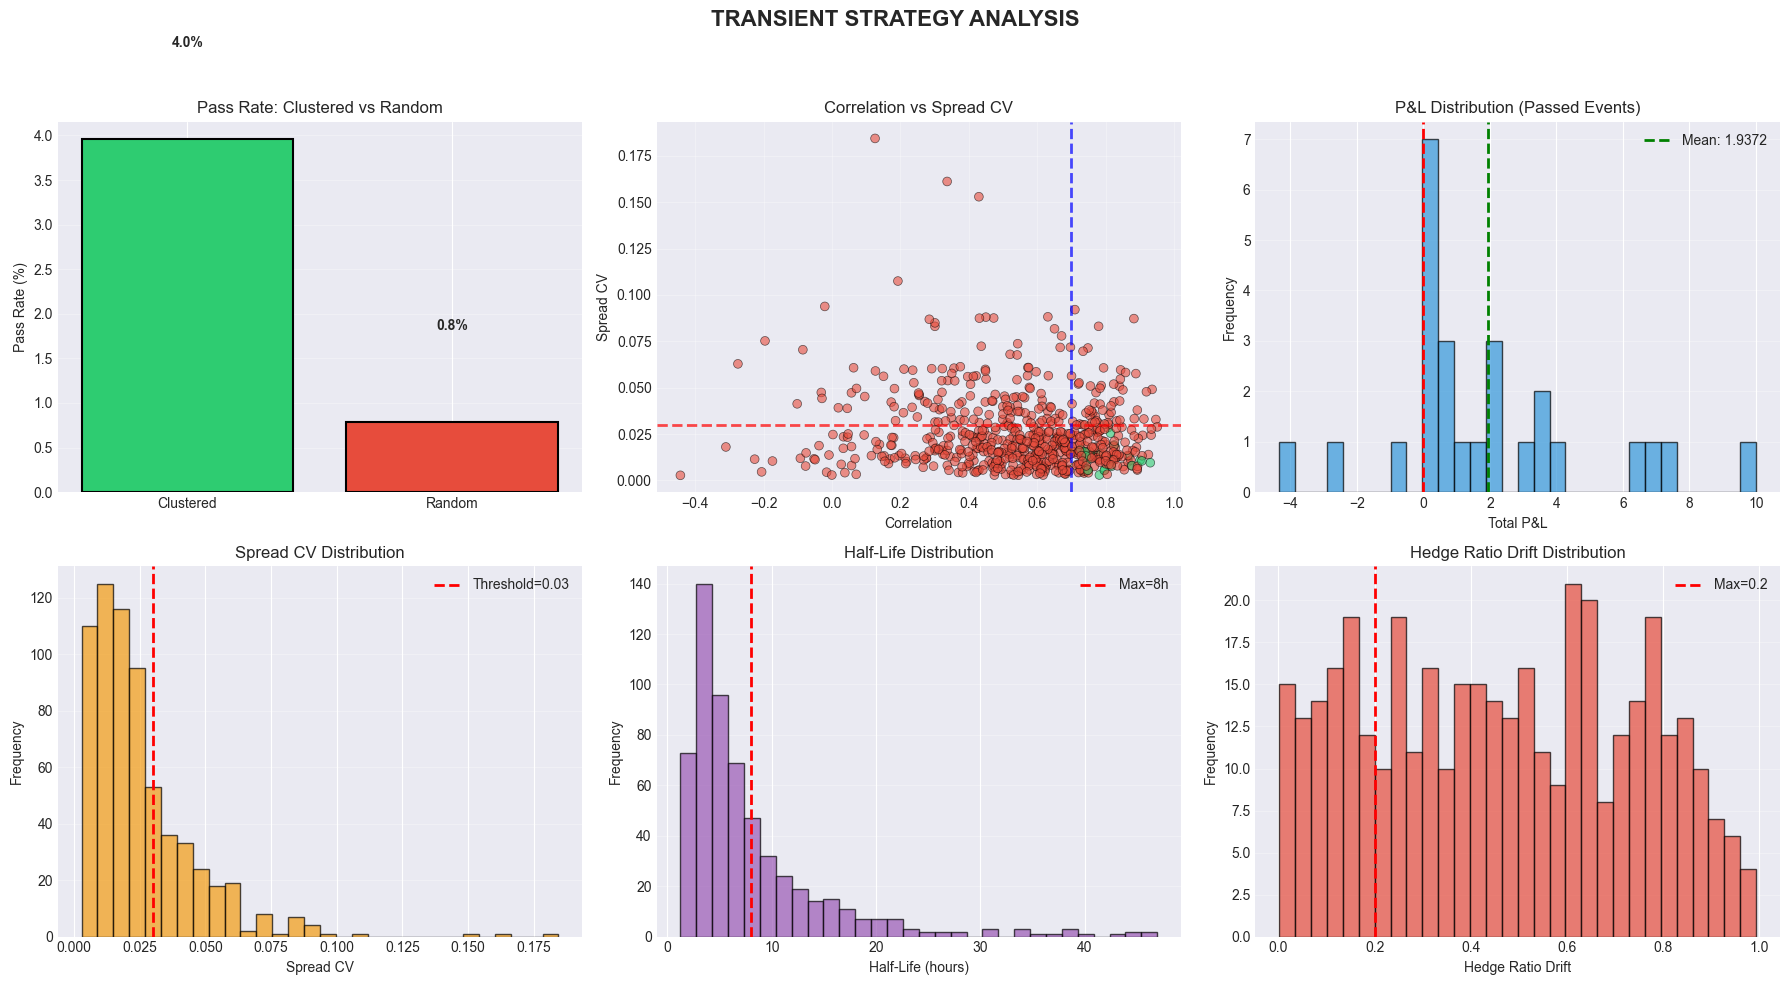

In [9]:
# ============================================================================
# TRANSIENT STRATEGY VISUALIZATIONS
# ============================================================================

if len(df_transient) == 0:
    print("No transient results to visualize.")
else:
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('TRANSIENT STRATEGY ANALYSIS', fontsize=16, fontweight='bold')

    # 1. Pass rates: clustered vs random
    ax = axes[0, 0]
    labels = ['Clustered']
    rates = [df_transient['passed'].mean() * 100]
    colors = ['#2ecc71']
    if len(df_random) > 0:
        labels.append('Random')
        rates.append(df_random['passed'].mean() * 100)
        colors.append('#e74c3c')
    bars = ax.bar(labels, rates, color=colors, edgecolor='black', linewidth=1.5)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., h + 1, f'{h:.1f}%',
                ha='center', va='bottom', fontweight='bold')
    ax.set_ylabel('Pass Rate (%)')
    ax.set_title('Pass Rate: Clustered vs Random')
    ax.grid(axis='y', alpha=0.3)

    # 2. Correlation vs Spread CV scatter
    ax = axes[0, 1]
    scatter_data = df_transient.dropna(subset=['correlation', 'spread_cv'])
    scatter_data = scatter_data[scatter_data['spread_cv'] < 0.2]
    if len(scatter_data) > 0:
        colors_scatter = scatter_data['passed'].map({True: '#2ecc71', False: '#e74c3c'})
        ax.scatter(scatter_data['correlation'], scatter_data['spread_cv'],
                   c=colors_scatter, alpha=0.6, s=40, edgecolors='black', linewidth=0.5)
        ax.axhline(y=TRANSIENT_CONFIG['CV_THRESHOLD'], color='red', linestyle='--', linewidth=2, alpha=0.7)
        ax.axvline(x=TRANSIENT_CONFIG['CORR_THRESHOLD'], color='blue', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Spread CV')
    ax.set_title('Correlation vs Spread CV')
    ax.grid(alpha=0.3)

    # 3. P&L distribution (passed events)
    ax = axes[0, 2]
    passed_pnl = df_transient[df_transient['passed']]['total_pnl'].dropna()
    if len(passed_pnl) > 0:
        ax.hist(passed_pnl, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
        ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
        ax.axvline(x=passed_pnl.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {passed_pnl.mean():.4f}')
        ax.legend()
    ax.set_xlabel('Total P&L')
    ax.set_ylabel('Frequency')
    ax.set_title('P&L Distribution (Passed Events)')
    ax.grid(axis='y', alpha=0.3)

    # 4. Spread CV distribution
    ax = axes[1, 0]
    cv_data = df_transient['spread_cv'].dropna()
    cv_data_clean = cv_data[cv_data < 0.2]
    if len(cv_data_clean) > 0:
        ax.hist(cv_data_clean, bins=30, color='#f39c12', alpha=0.7, edgecolor='black')
        ax.axvline(x=TRANSIENT_CONFIG['CV_THRESHOLD'], color='red', linestyle='--', linewidth=2,
                   label=f'Threshold={TRANSIENT_CONFIG["CV_THRESHOLD"]}')
        ax.legend()
    ax.set_xlabel('Spread CV')
    ax.set_ylabel('Frequency')
    ax.set_title('Spread CV Distribution')
    ax.grid(axis='y', alpha=0.3)

    # 5. Half-life distribution
    ax = axes[1, 1]
    hl_data = df_transient['half_life'].replace([np.inf], np.nan).dropna()
    hl_data_clean = hl_data[hl_data < 50]
    if len(hl_data_clean) > 0:
        ax.hist(hl_data_clean, bins=30, color='#9b59b6', alpha=0.7, edgecolor='black')
        ax.axvline(x=TRANSIENT_CONFIG['HL_MAX'], color='red', linestyle='--', linewidth=2,
                   label=f'Max={TRANSIENT_CONFIG["HL_MAX"]}h')
        ax.legend()
    ax.set_xlabel('Half-Life (hours)')
    ax.set_ylabel('Frequency')
    ax.set_title('Half-Life Distribution')
    ax.grid(axis='y', alpha=0.3)

    # 6. Hedge drift distribution
    ax = axes[1, 2]
    drift_data = df_transient['hedge_drift'].dropna()
    drift_clean = drift_data[drift_data < 1.0]
    if len(drift_clean) > 0:
        ax.hist(drift_clean, bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
        ax.axvline(x=TRANSIENT_CONFIG['HEDGE_DRIFT_MAX'], color='red', linestyle='--', linewidth=2,
                   label=f'Max={TRANSIENT_CONFIG["HEDGE_DRIFT_MAX"]}')
        ax.legend()
    ax.set_xlabel('Hedge Ratio Drift')
    ax.set_ylabel('Frequency')
    ax.set_title('Hedge Ratio Drift Distribution')
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

Visualizing top 6 opportunities by P&L:



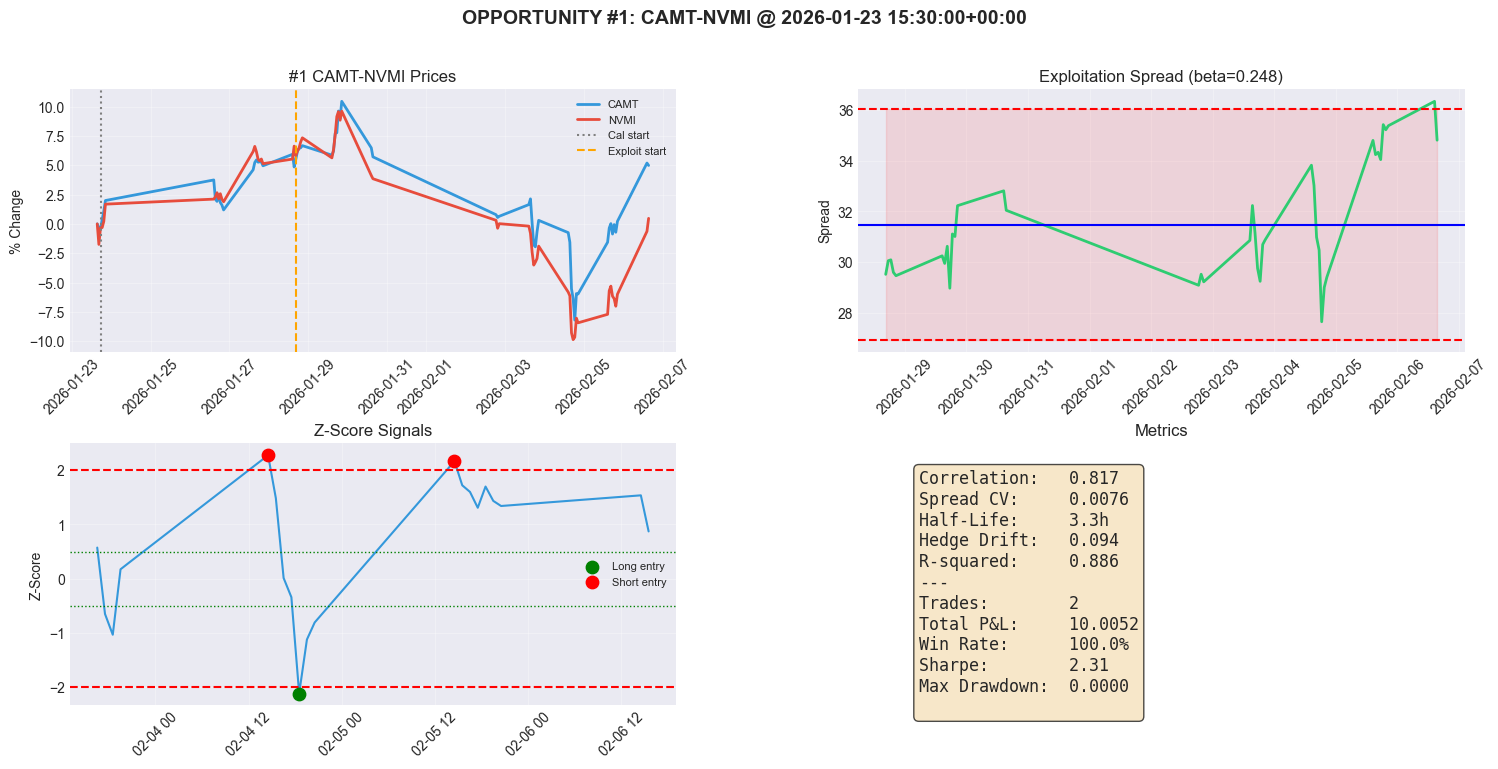

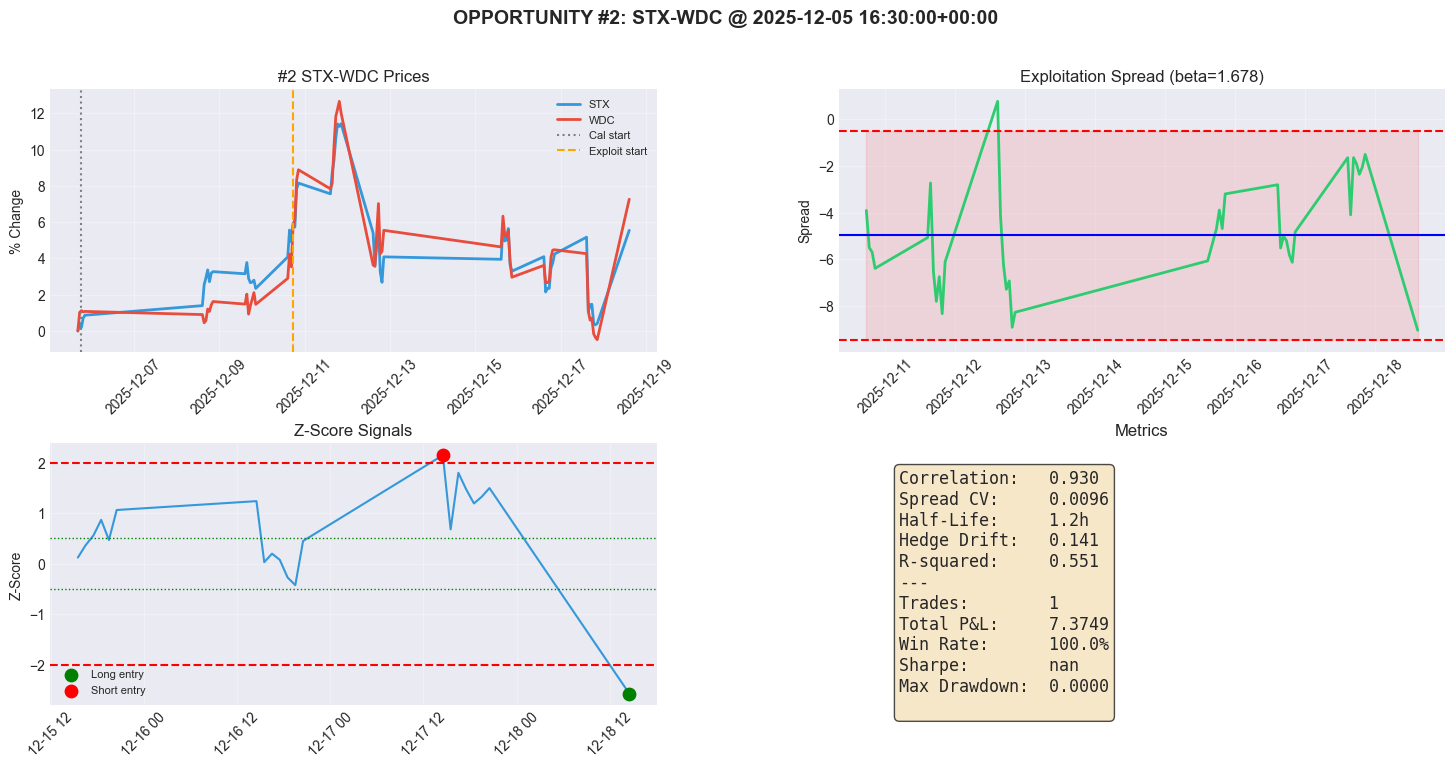

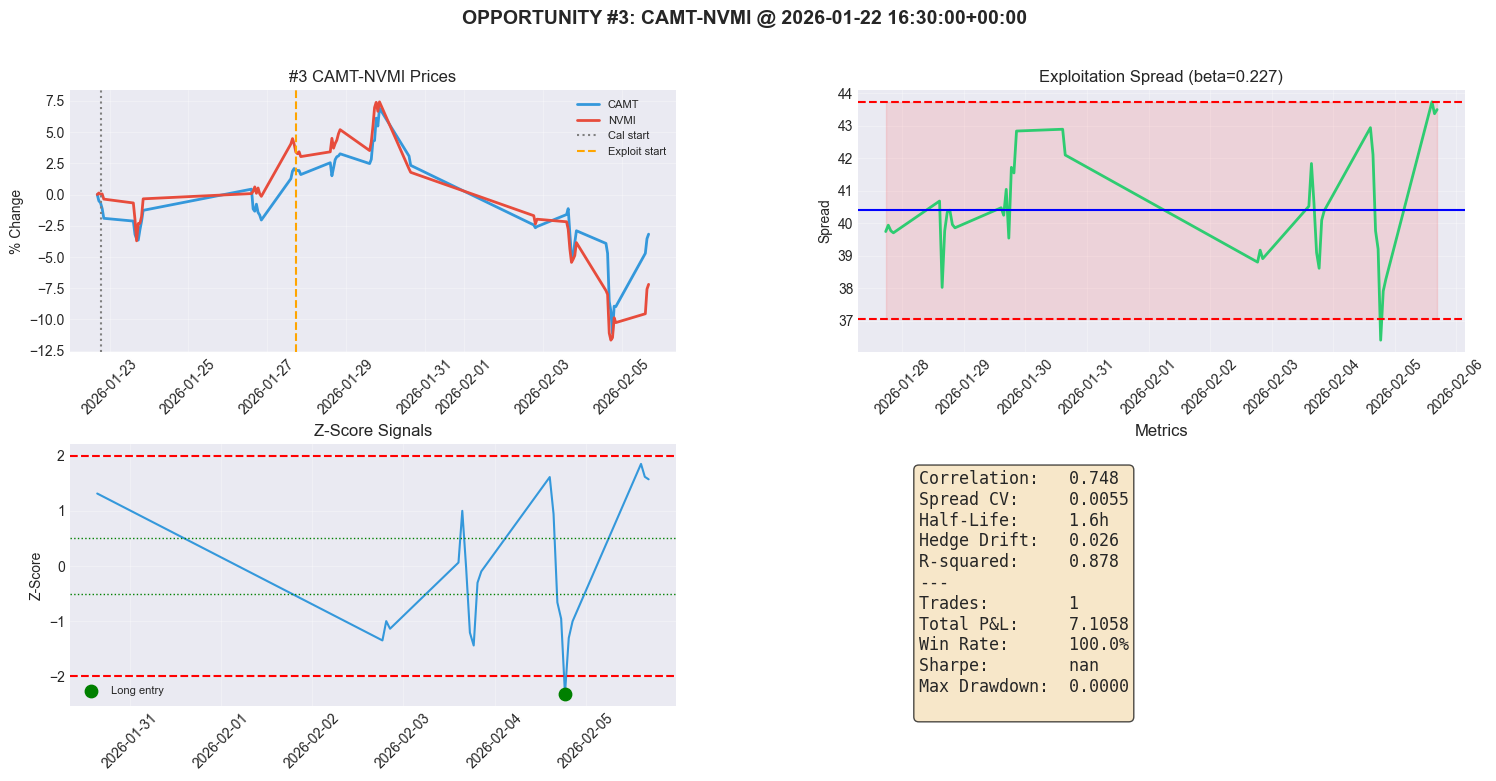

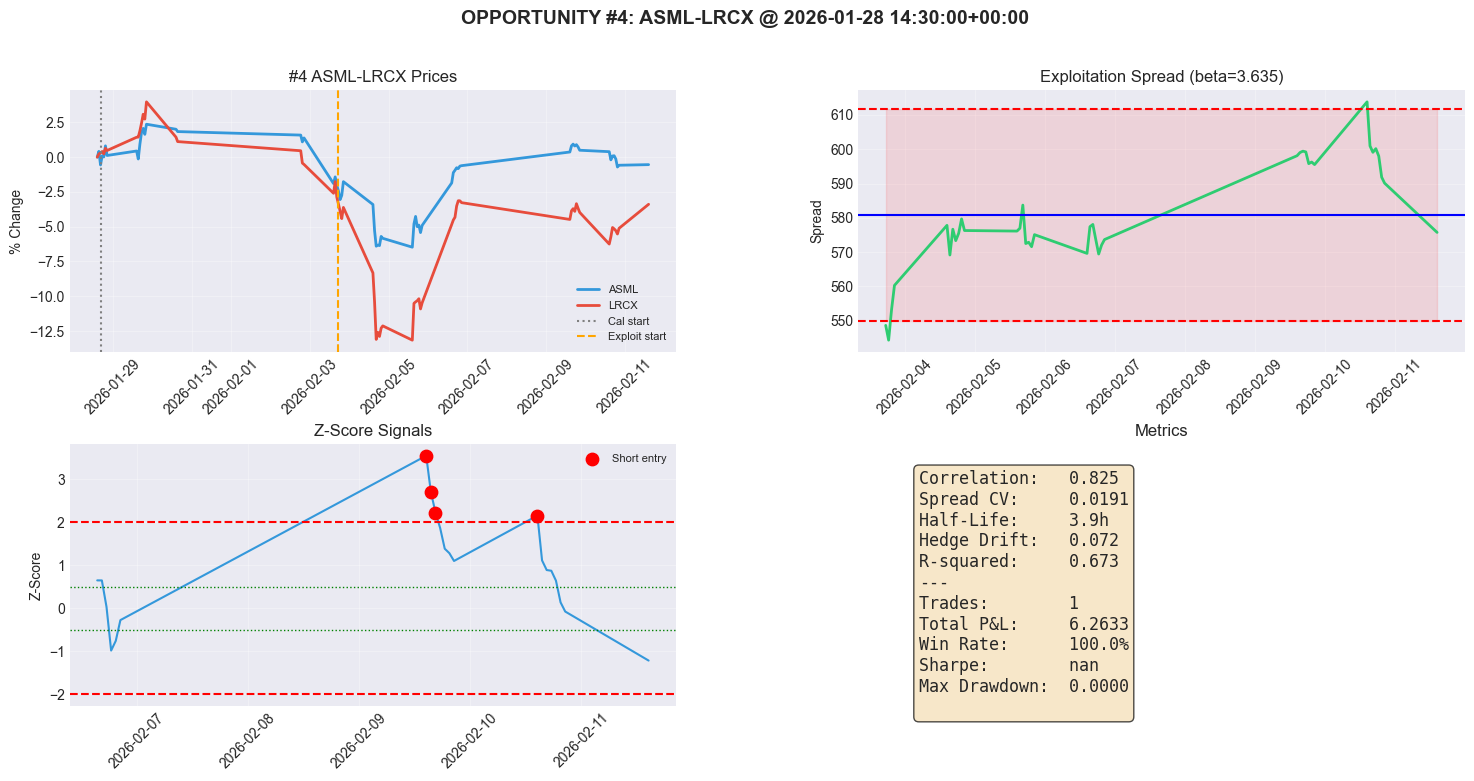

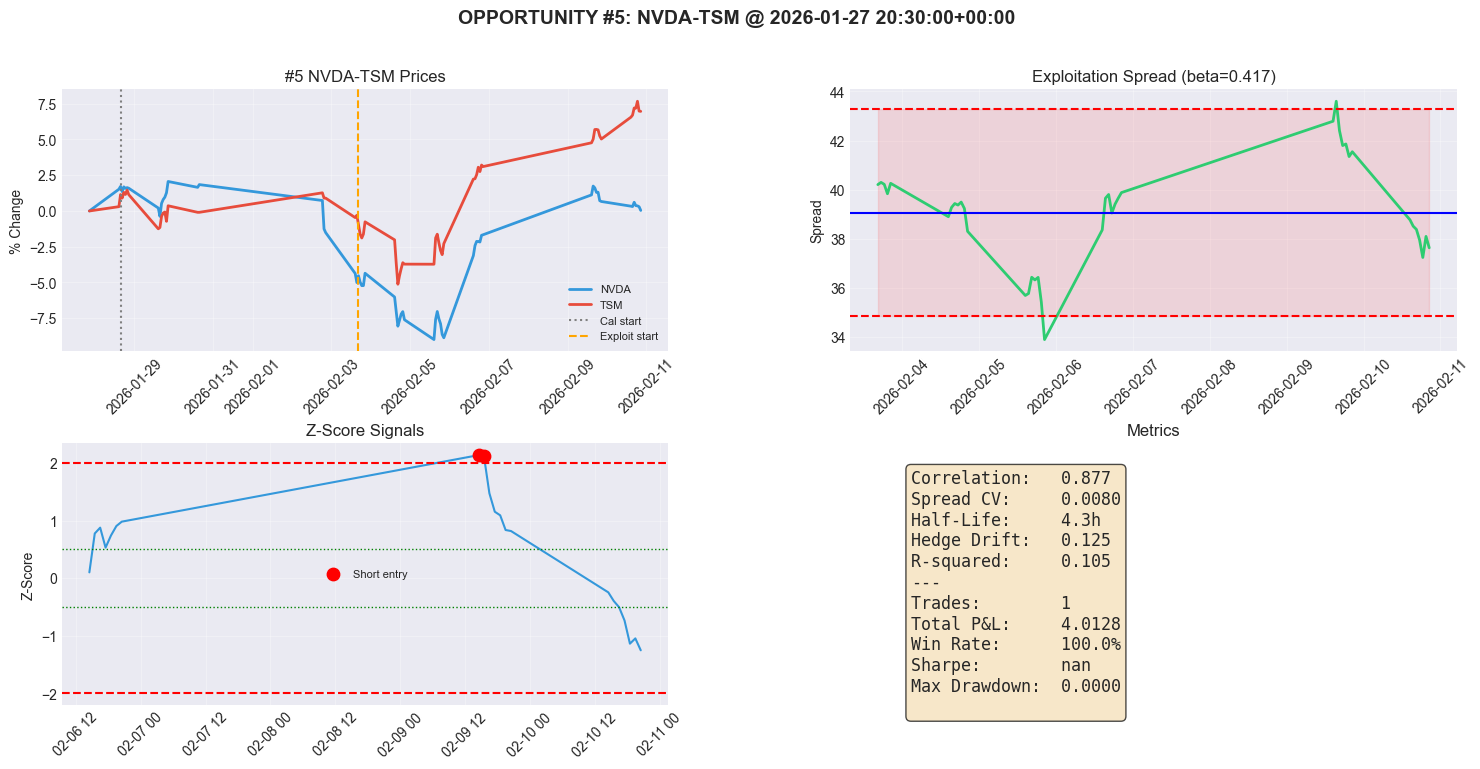

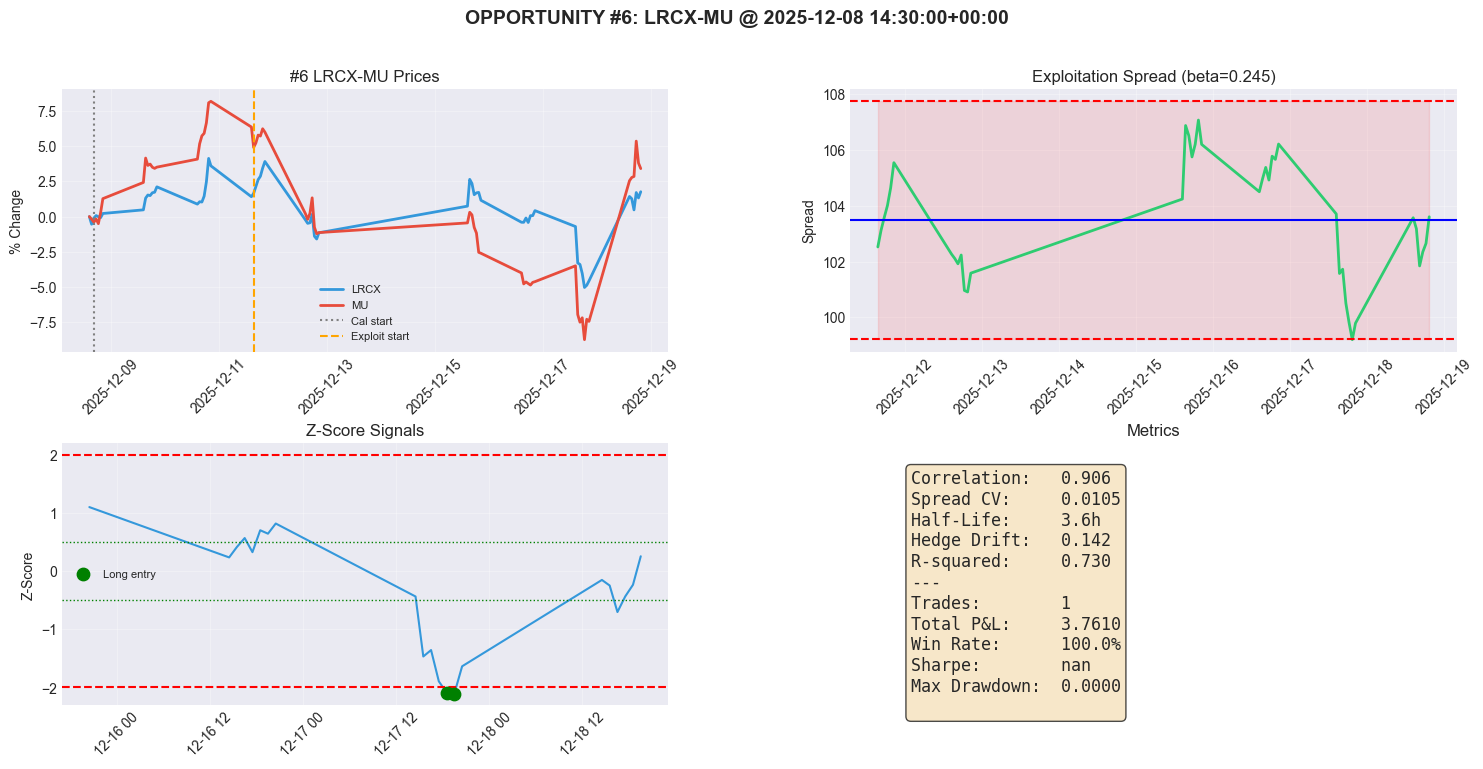

In [10]:
# ============================================================================
# INDIVIDUAL OPPORTUNITY VISUALIZATIONS
# ============================================================================

if len(df_transient) > 0 and df_transient['passed'].sum() > 0:
    passed_events = df_transient[df_transient['passed']].sort_values('total_pnl', ascending=False)
    selected = passed_events.head(6)

    print(f"Visualizing top {len(selected)} opportunities by P&L:\n")

    for fig_num, (_, opp) in enumerate(selected.iterrows(), 1):
        ticker_a = opp['ticker_a']
        ticker_b = opp['ticker_b']
        timestamp = opp['timestamp']
        lag = TRANSIENT_CONFIG['EXECUTION_LAG']
        cal_len = TRANSIENT_CONFIG['CALIBRATION']
        exploit_len = TRANSIENT_CONFIG['EXPLOITATION']
        total_need = lag + cal_len + exploit_len

        prices_a = get_price_window(ticker_a, timestamp, total_need, ts_df, direction='forward')
        prices_b = get_price_window(ticker_b, timestamp, total_need, ts_df, direction='forward')

        if len(prices_a) < total_need or len(prices_b) < total_need:
            continue

        common_idx = prices_a.index.intersection(prices_b.index)
        pa = prices_a.loc[common_idx]
        pb = prices_b.loc[common_idx]

        # Windows
        pa_cal = pa.iloc[lag:lag + cal_len]
        pb_cal = pb.iloc[lag:lag + cal_len]
        pa_exp = pa.iloc[lag + cal_len:lag + cal_len + exploit_len]
        pb_exp = pb.iloc[lag + cal_len:lag + cal_len + exploit_len]

        beta_cal = opp['beta_cal']
        spread_exp = pa_exp - beta_cal * pb_exp
        spread_mean = spread_exp.mean()
        spread_std = spread_exp.std()

        lookback = min(20, len(spread_exp) // 2)
        if lookback < 5:
            lookback = 5
        signals = zscore_signals(spread_exp, lookback=lookback, entry_z=2.0, exit_z=0.5)

        fig = plt.figure(figsize=(18, 8))
        gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.35, wspace=0.3)

        # Panel 1: Normalized prices with window boundaries
        ax1 = fig.add_subplot(gs[0, 0])
        norm_a = (pa / pa.iloc[0] - 1) * 100
        norm_b = (pb / pb.iloc[0] - 1) * 100
        ax1.plot(pa.index, norm_a, label=ticker_a, color='#3498db', linewidth=2)
        ax1.plot(pb.index, norm_b, label=ticker_b, color='#e74c3c', linewidth=2)
        # Mark calibration / exploitation boundaries
        if lag < len(pa):
            ax1.axvline(x=pa.index[lag], color='gray', linestyle=':', linewidth=1.5, label='Cal start')
        if lag + cal_len < len(pa):
            ax1.axvline(x=pa.index[lag + cal_len], color='orange', linestyle='--', linewidth=1.5, label='Exploit start')
        ax1.set_ylabel('% Change')
        ax1.set_title(f'#{fig_num} {ticker_a}-{ticker_b} Prices')
        ax1.legend(fontsize=8)
        ax1.grid(alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)

        # Panel 2: Spread with bands
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(spread_exp.index, spread_exp, color='#2ecc71', linewidth=2, label='Spread')
        ax2.axhline(y=spread_mean, color='blue', linewidth=1.5)
        ax2.axhline(y=spread_mean + 2*spread_std, color='red', linestyle='--', linewidth=1.5)
        ax2.axhline(y=spread_mean - 2*spread_std, color='red', linestyle='--', linewidth=1.5)
        ax2.fill_between(spread_exp.index, spread_mean - 2*spread_std, spread_mean + 2*spread_std,
                         alpha=0.1, color='red')
        ax2.set_ylabel('Spread')
        ax2.set_title(f'Exploitation Spread (beta={beta_cal:.3f})')
        ax2.grid(alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)

        # Panel 3: Z-score + signals
        ax3 = fig.add_subplot(gs[1, 0])
        z = signals['z_score'].dropna()
        ax3.plot(z.index, z, color='#3498db', linewidth=1.5)
        ax3.axhline(y=2.0, color='red', linestyle='--', linewidth=1.5)
        ax3.axhline(y=-2.0, color='red', linestyle='--', linewidth=1.5)
        ax3.axhline(y=0.5, color='green', linestyle=':', linewidth=1)
        ax3.axhline(y=-0.5, color='green', linestyle=':', linewidth=1)
        # Mark entry signals
        long_entries = signals[signals['long_entry']].index
        short_entries = signals[signals['short_entry']].index
        if len(long_entries) > 0:
            ax3.scatter(long_entries, z.loc[long_entries], color='green', s=80, zorder=5, label='Long entry')
        if len(short_entries) > 0:
            ax3.scatter(short_entries, z.loc[short_entries], color='red', s=80, zorder=5, label='Short entry')
        ax3.set_ylabel('Z-Score')
        ax3.set_title('Z-Score Signals')
        ax3.legend(fontsize=8)
        ax3.grid(alpha=0.3)
        ax3.tick_params(axis='x', rotation=45)

        # Panel 4: Metrics summary
        ax4 = fig.add_subplot(gs[1, 1])
        ax4.axis('off')
        metrics_text = (
            f"Correlation:   {opp['correlation']:.3f}\n"
            f"Spread CV:     {opp['spread_cv']:.4f}\n"
            f"Half-Life:     {opp['half_life']:.1f}h\n"
            f"Hedge Drift:   {opp['hedge_drift']:.3f}\n"
            f"R-squared:     {opp['r_squared_cal']:.3f}\n"
            f"---\n"
            f"Trades:        {opp['n_trades']}\n"
            f"Total P&L:     {opp['total_pnl']:.4f}\n"
            f"Win Rate:      {opp['win_rate']:.1%}\n"
            f"Sharpe:        {opp['sharpe']:.2f}\n"
            f"Max Drawdown:  {opp['max_drawdown']:.4f}\n"
        )
        ax4.text(0.1, 0.9, metrics_text, transform=ax4.transAxes, fontsize=12,
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
        ax4.set_title('Metrics')

        fig.suptitle(f'OPPORTUNITY #{fig_num}: {ticker_a}-{ticker_b} @ {timestamp}',
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("No passed transient events to visualize.")

## Real-Time Signal Functions

In [11]:
# ============================================================================
# REAL-TIME SIGNAL FUNCTIONS (FIX 4)
# ============================================================================
# These replace the GradientBoosting prediction model from the old
# optics-prediction notebook.  They provide actionable interface definitions
# for production use.

def detect_new_formations(cluster_history_latest, previous_clusters):
    """
    Compare latest clustering snapshot to previous snapshot.
    Identify new co-clustering events (pair transitions from
    not-co-clustered to co-clustered).

    Parameters
    ----------
    cluster_history_latest : DataFrame
        Latest snapshot with columns ['Ticker', 'Cluster_ID'].
    previous_clusters : dict
        Mapping ticker -> cluster_id from the previous timestamp.

    Returns
    -------
    list of tuple (ticker_a, ticker_b) representing new formations.
    """
    import itertools

    current_clusters = {}
    for _, row in cluster_history_latest.iterrows():
        if row['Cluster_ID'] != -1:
            current_clusters[row['Ticker']] = row['Cluster_ID']

    # Find pairs co-clustering now
    current_pairs = set()
    for cid in set(current_clusters.values()):
        members = sorted([t for t, c in current_clusters.items() if c == cid])
        for a, b in itertools.combinations(members, 2):
            current_pairs.add((a, b))

    # Find pairs co-clustering previously
    prev_pairs = set()
    for cid in set(previous_clusters.values()):
        members = sorted([t for t, c in previous_clusters.items() if c == cid])
        for a, b in itertools.combinations(members, 2):
            prev_pairs.add((a, b))

    # New formations = currently co-clustered but not previously
    new_formations = current_pairs - prev_pairs
    return list(new_formations)


def generate_transient_signals(ticker_a, ticker_b, ts_df, config):
    """
    For a given pair, compute the current z-score and return a signal dict.

    Parameters
    ----------
    config : dict with CALIBRATION, EXECUTION_LAG, ENTRY_Z, EXIT_Z.

    Returns
    -------
    dict with z_score, signal ('long', 'short', 'exit', 'wait'), spread_cv, half_life.
    """
    from validation.pair_validation import (
        compute_hedge_ratio, spread_cv_normalized, half_life as hl_func,
        zscore_signals,
    )

    cal_len = config.get('CALIBRATION', 10)
    ticker_data_a = ts_df.xs(ticker_a, level='Ticker').sort_index()['Price']
    ticker_data_b = ts_df.xs(ticker_b, level='Ticker').sort_index()['Price']

    if len(ticker_data_a) < cal_len + 10 or len(ticker_data_b) < cal_len + 10:
        return None

    common = ticker_data_a.index.intersection(ticker_data_b.index)
    pa = ticker_data_a.loc[common]
    pb = ticker_data_b.loc[common]

    # Calibration on last cal_len observations
    pa_cal = pa.iloc[-cal_len - 10:-10]
    pb_cal = pb.iloc[-cal_len - 10:-10]
    pa_recent = pa.iloc[-10:]
    pb_recent = pb.iloc[-10:]

    beta, _, _ = compute_hedge_ratio(pa_cal, pb_cal)

    # Use calibration window for baseline stats (not recent window)
    spread_cal = pa_cal - beta * pb_cal
    mu = spread_cal.mean()
    sd = spread_cal.std()

    # CV and half-life on calibration window (recent is too short)
    cv = spread_cv_normalized(spread_cal, pa_cal, pb_cal)
    hl = hl_func(spread_cal)

    # Score current observation against calibration baseline
    spread_recent = pa_recent - beta * pb_recent
    z = (spread_recent.iloc[-1] - mu) / sd if sd > 0 else 0.0

    entry_z = config.get('ENTRY_Z', 2.0)
    exit_z = config.get('EXIT_Z', 0.5)

    if z >= entry_z:
        signal = 'short'
    elif z <= -entry_z:
        signal = 'long'
    elif abs(z) <= exit_z:
        signal = 'exit'
    else:
        signal = 'wait'

    return {
        'ticker_a': ticker_a,
        'ticker_b': ticker_b,
        'z_score': float(z),
        'signal': signal,
        'beta': float(beta),
        'spread_cv': float(cv) if not np.isnan(cv) else None,
        'half_life': float(hl) if not np.isnan(hl) and hl != np.inf else None,
    }


def track_stable_pairs(pair_list, ts_df, config):
    """
    Daily cointegration check and Bollinger position for a list of stable pairs.

    Parameters
    ----------
    pair_list : list of (ticker_a, ticker_b)
    config : dict (not used currently, placeholder for thresholds)

    Returns
    -------
    list of dicts with pair, coint_pval, z_score, signal.
    """
    from validation.pair_validation import compute_hedge_ratio
    from statsmodels.tsa.stattools import coint

    results = []
    for ticker_a, ticker_b in pair_list:
        try:
            da = ts_df.xs(ticker_a, level='Ticker').sort_index()['Price'].resample('1D').last().dropna()
            db = ts_df.xs(ticker_b, level='Ticker').sort_index()['Price'].resample('1D').last().dropna()
        except Exception:
            continue

        common = da.index.intersection(db.index)
        if len(common) < 50:
            continue

        da = da.loc[common]
        db = db.loc[common]

        try:
            _, pval, _ = coint(da, db)
        except Exception:
            pval = 1.0

        beta, _, _ = compute_hedge_ratio(da, db)
        spread = da - beta * db
        mu = spread.rolling(20).mean()
        sd = spread.rolling(20).std()
        z_latest = (spread.iloc[-1] - mu.iloc[-1]) / sd.iloc[-1] if sd.iloc[-1] > 0 else 0.0

        if z_latest >= 2.0:
            signal = 'short'
        elif z_latest <= -2.0:
            signal = 'long'
        elif abs(z_latest) <= 0.5:
            signal = 'exit'
        else:
            signal = 'hold'

        results.append({
            'pair': f'{ticker_a}-{ticker_b}',
            'coint_pval': float(pval),
            'z_score': float(z_latest),
            'signal': signal,
            'beta': float(beta),
        })

    return results


print("Signal functions defined:")
print("  - detect_new_formations(cluster_history_latest, previous_clusters)")
print("  - generate_transient_signals(ticker_a, ticker_b, ts_df, config)")
print("  - track_stable_pairs(pair_list, ts_df, config)")
print("\nThese replace the GradientBoosting prediction model.")
print("Ready for production integration.")

Signal functions defined:
  - detect_new_formations(cluster_history_latest, previous_clusters)
  - generate_transient_signals(ticker_a, ticker_b, ts_df, config)
  - track_stable_pairs(pair_list, ts_df, config)

These replace the GradientBoosting prediction model.
Ready for production integration.
